<a href="https://colab.research.google.com/github/muhammadAkbar7/-Machine-Learning-For-Engineers-Final-Project/blob/main/CEE_415_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# load data
path = "/gdrive/My Drive/415 project"
data = pd.read_csv(path + "/traffic.csv")

In [ ]:
data.head(5)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [ ]:
data.shape

(48120, 3)

# Plotting, EDA

Text(0.5, 0, 'Date')

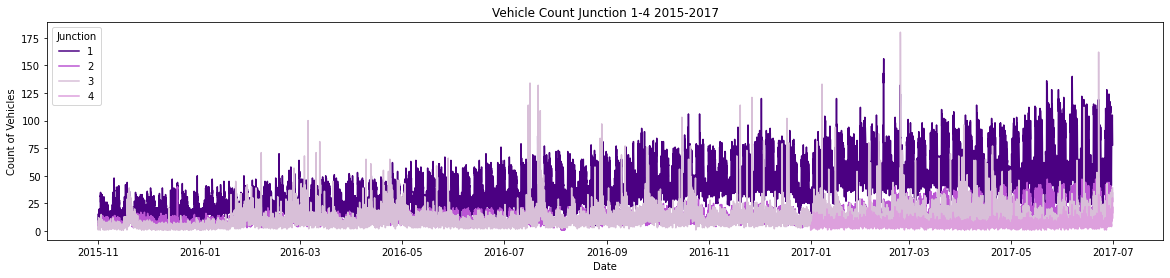

In [ ]:
#Exploratory Data Analysis
df = data.copy()
#Let's plot the Timeseries
colors = [ "indigo","mediumorchid","thistle","plum"]
plt.figure(figsize=(20,4))
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Vehicle Count Junction 1-4 2015-2017")
Time_series.set_ylabel("Count of Vehicles")
Time_series.set_xlabel("Date")

Adding Datetime features

In [ ]:
from google.colab import files
#Creating new features by extracting date information
df["year"]= df['DateTime'].dt.year
df["month"]= df['DateTime'].dt.month
df["day_month"]= df['DateTime'].dt.day
df["hour"]= df['DateTime'].dt.hour
df["day"]= df.DateTime.dt.strftime("%A")
df.head(10)
df.to_csv('traffic_data.csv', encoding = 'utf-8-sig') 
files.download('traffic_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

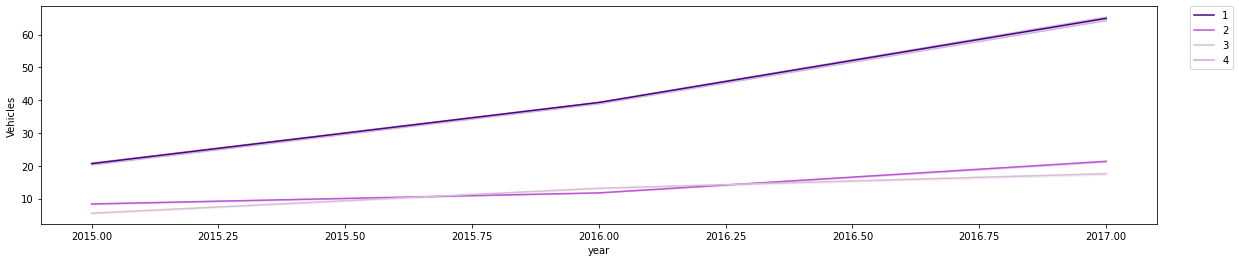

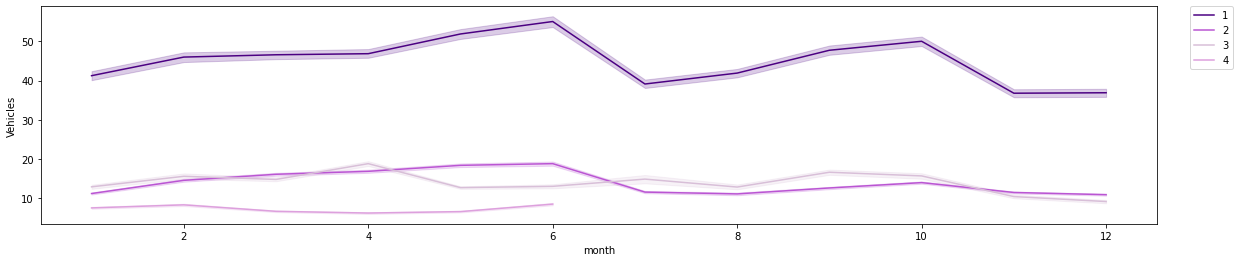

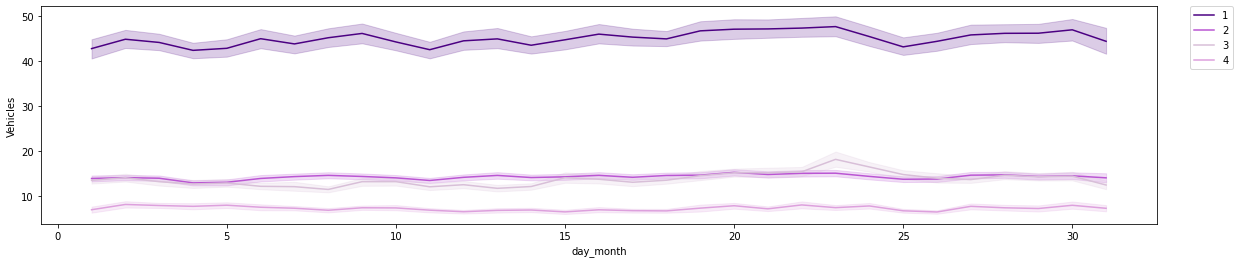

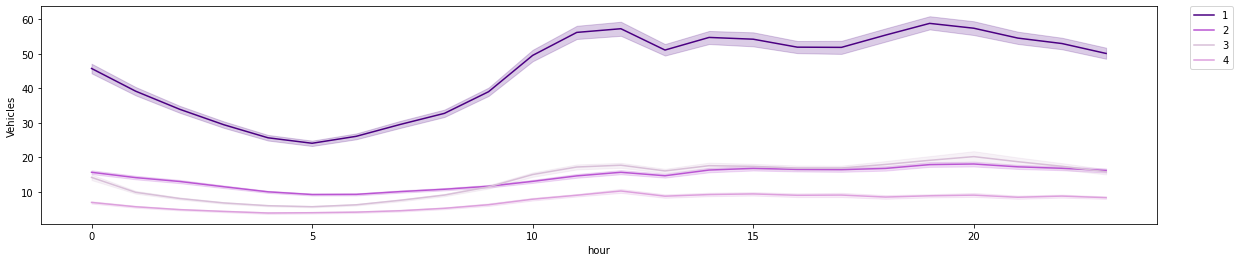

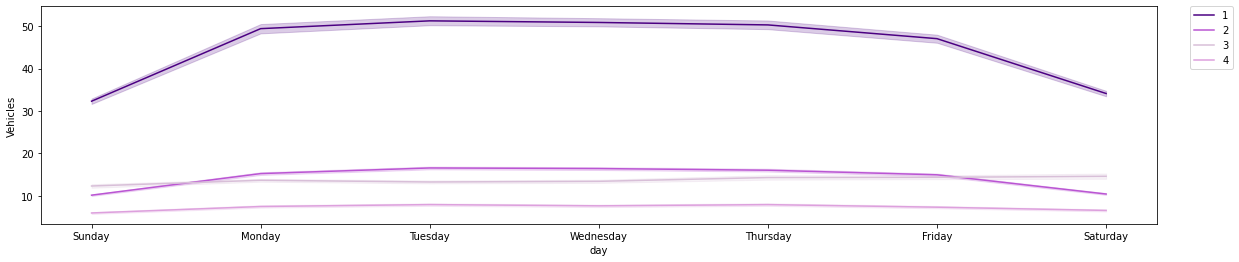

In [ ]:
#plot new features with restpect to veh count

date_features = ['year','month','day_month','hour','day']

for i in date_features:
    plt.figure(figsize=(20,4))
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)

In [ ]:
#Pivoting data fron junction 
df_junc = data.pivot(columns="Junction", index="DateTime")
df_junc.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

Using this website as a go by for time series forecasting

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [ ]:
#separate the data frame into a df per junction
df_1 = df.loc[df.Junction== 1]
df_2 = df.loc[df.Junction== 2]
#df_3 = df.loc[df.Junction== 3]
#df_4 = df.loc[df.Junction== 4]
#df_1

# Data Cleaning/Check

In [ ]:
#drop unecassary column
df_1 = df_1.drop(["DateTime","Junction"], axis=1)

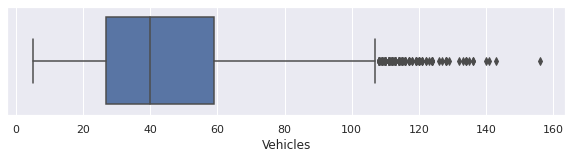

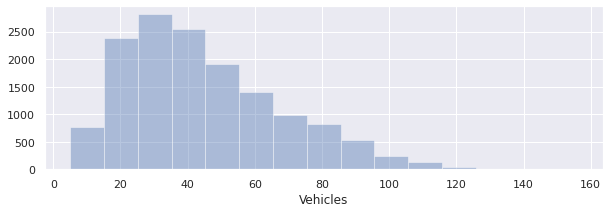

In [ ]:
sns.set(rc={'figure.figsize':(10,2)})
sns.boxplot(x = df_1['Vehicles'])
plt.show()
sns.set(rc={'figure.figsize':(10,3)})
bin_count = int(np.ceil(np.log2(len(df_1))) + 1)
sns.distplot(df_1['Vehicles'], bins = bin_count, kde = False)
plt.show()

In [ ]:
#check duplicates
dup_check = df_1.duplicated()
dup_count = sum(dup_check)
dup_count

0

# Create Model

In [ ]:
#hot one encode of 
df_1 = pd.get_dummies(df_1, prefix=['day'], columns=['day'])
df_1

,Vehicles,year,month,day_month,hour,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,15,2015,11,1,0,0,0,0,1,0,0,0
1,13,2015,11,1,1,0,0,0,1,0,0,0
2,10,2015,11,1,2,0,0,0,1,0,0,0
3,7,2015,11,1,3,0,0,0,1,0,0,0
4,9,2015,11,1,4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14587,105,2017,6,30,19,1,0,0,0,0,0,0
14588,96,2017,6,30,20,1,0,0,0,0,0,0
14589,90,2017,6,30,21,1,0,0,0,0,0,0
14590,84,2017,6,30,22,1,0,0,0,0,0,0


In [ ]:
# Labels are the values we want to predict
labels = np.array(df_1['Vehicles'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df_1.drop('Vehicles', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (10944, 11)
Training Labels Shape: (10944,)
Testing Features Shape: (3648, 11)
Testing Labels Shape: (3648,)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Count.')
predictions.shape

Mean Absolute Error: 2.89 Count.


(3648,)

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 92.37 %.


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: year                 Importance: 0.38
Variable: hour                 Importance: 0.29
Variable: month                Importance: 0.13
Variable: day_Saturday         Importance: 0.07
Variable: day_Sunday           Importance: 0.07
Variable: day_month            Importance: 0.03
Variable: day_Friday           Importance: 0.01
Variable: day_Monday           Importance: 0.01
Variable: day_Thursday         Importance: 0.0
Variable: day_Tuesday          Importance: 0.0
Variable: day_Wednesday        Importance: 0.0


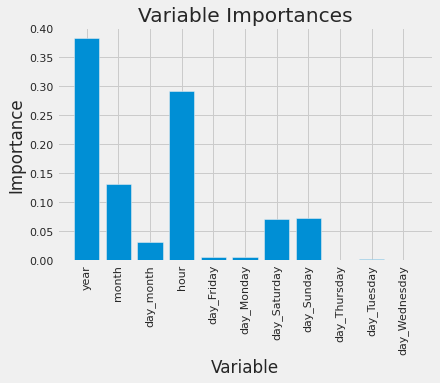

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');



```
# This is formatted as code
```

# Plot predictions

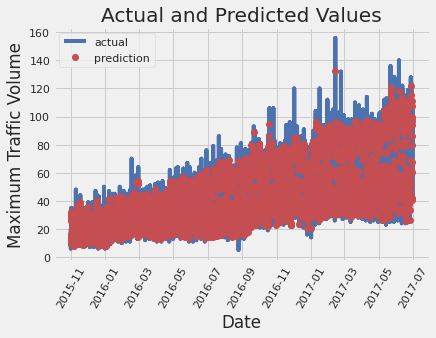

In [ ]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day_month')]
years = features[:, feature_list.index('year')]
#hour = features[:, feature_list.index('hour')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) + ' ' + str() for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date.strip(), '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day_month')]
years = test_features[:, feature_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Traffic Volume'); plt.title('Actual and Predicted Values');
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
true_data

,date,actual
0,2015-11-01,15
1,2015-11-01,13
2,2015-11-01,10
3,2015-11-01,7
4,2015-11-01,9
...,...,...
14587,2017-06-30,105
14588,2017-06-30,96
14589,2017-06-30,90
14590,2017-06-30,84
